In [ ]:
from google.colab import drive
import sys
import os
import random
import numpy as np
import cv2

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

In [ ]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
#import tensorflow_datasets as tfds
import numpy as np

In [ ]:
# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/ADNI'

#Test and Train Folders
test_folder = "/content/drive/My Drive/Colab Notebooks/ADNI/Processed/test"
train_folder = "/content/drive/My Drive/Colab Notebooks/ADNI/Processed/train"

In [ ]:
img_size=[299,299]
batch = 32
split = 0.2

epoch_n = 20
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
np.random.seed(random_seed)

In [ ]:
data_tr = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder, labels='inferred',  class_names=None,
    color_mode='rgb', batch_size=batch, image_size=img_size, seed=random_seed,
    validation_split=split, subset='training', interpolation='bilinear'
)

data_val = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder, labels='inferred',  class_names=None,
    color_mode='rgb', batch_size=batch, image_size=img_size, seed=random_seed,
    validation_split=split, subset='validation', interpolation='bilinear'
)

data_te = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder, labels='inferred',  class_names=None,
    color_mode='rgb', batch_size=batch, image_size=img_size, seed=random_seed,
    validation_split=None, subset=None, interpolation='bilinear'
)

Found 19215 files belonging to 3 classes.
Using 15372 files for training.
Found 19215 files belonging to 3 classes.
Using 3843 files for validation.
Found 4851 files belonging to 3 classes.


In [ ]:
data_te = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder, labels='inferred',  class_names=None,
    color_mode='rgb', batch_size=batch, image_size=img_size, seed=random_seed,
    validation_split=None, subset=None, interpolation='bilinear'
)

Found 4851 files belonging to 3 classes.


In [ ]:
#Training Data
class_names_tr = data_tr.class_names
print(class_names_tr)

for images, labels in data_tr.take(1): 
  print(images.shape, labels.shape)

['AD', 'CN', 'MCI']
(32, 299, 299, 3) (32,)


In [ ]:
#Validation Data
class_names_val = data_val.class_names
print(class_names_val)

for images, labels in data_val.take(1): 
  print(images.shape, labels.shape)

['AD', 'CN', 'MCI']
(32, 299, 299, 3) (32,)


In [ ]:
#Test Data
class_names_te = data_te.class_names
print(class_names_te)

for images, labels in data_te.take(1): 
  print(images.shape, labels.shape)

['AD', 'CN', 'MCI']
(32, 299, 299, 3) (32,)


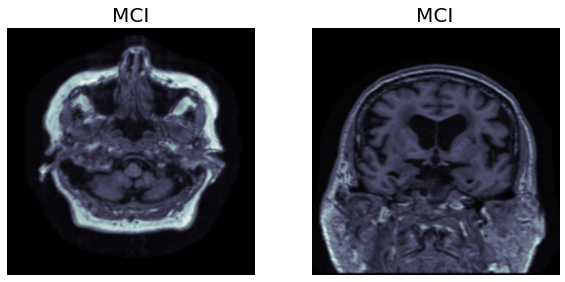

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data_tr.take(1):
  for i in range(2):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap = 'bone')
    plt.title(class_names_tr[labels[i]])
    plt.axis("off")

In [ ]:
# Set the preprocess_input of the pretrained model
global preprocess_input
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [ ]:
#code from https://github.com/kristinslevine/teaching/blob/master/gwu/machine_learning_I/fall_2020/code/utilities/p3_deep_learning/pmlm_utilities_deep.ipynb

def preprocess_pretrain(data, label):
    """
    Preprocess the data using pretrained model

    Parameters
    ----------
    data: the data
    label: the label
    
    Returns
    ----------
    The preprocessed data using pretrained model
    """

    # Preprocess the data
    data_preprocessed = preprocess_input(data)

    return data_preprocessed, label

In [ ]:
# Preprocess the training data using pretrained model
data_train = data_tr.map(preprocess_pretrain)

# Preprocess the validation data using pretrained model
data_valid = data_val.map(preprocess_pretrain)

# Preprocess the test data using pretrained model
data_test = data_te.map(preprocess_pretrain)

In [ ]:

# Preprocess the test data using pretrained model
data_test = data_te.map(preprocess_pretrain)

In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
#Loading Xception Model

# Add the pretrained layers
pretrained_model = keras.applications.Xception(include_top=False, weights='imagenet')

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add Dropout 
drop = keras.layers.Dropout(0.3)
dropout = drop(average_pooling)

# Add the output layer
output = keras.layers.Dense(3, activation='softmax')(dropout)

# Get the model
model = keras.Model(inputs=pretrained_model.input, outputs=output)

#model.summary()

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
# For each layer in the pretrained model
for layer in pretrained_model.layers:
    # Freeze the layer
    layer.trainable = False

In [ ]:
# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + '/result/Xception_model.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True)

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                            patience=2)

In [ ]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train, evaluate and save the best model
history = model.fit(data_train,
                    epochs=20,
                    validation_data=data_valid,
                    callbacks=[model_checkpoint_cb,
                               early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/20
481/481 [==============================] - 1008s 2s/step - loss: 1.4226 - accuracy: 0.3947 - val_loss: 1.1364 - val_accuracy: 0.3763 - lr: 0.0010
Epoch 2/20
481/481 [==============================] - 133s 275ms/step - loss: 1.1066 - accuracy: 0.4223 - val_loss: 0.9846 - val_accuracy: 0.4941 - lr: 0.0010
Epoch 3/20
481/481 [==============================] - 146s 302ms/step - loss: 1.0785 - accuracy: 0.4458 - val_loss: 0.9979 - val_accuracy: 0.4666 - lr: 0.0010
Epoch 4/20
481/481 [==============================] - 130s 269ms/step - loss: 1.0541 - accuracy: 0.4558 - val_loss: 0.9870 - val_accuracy: 0.4840 - lr: 0.0010
Epoch 5/20
481/481 [==============================] - 132s 272ms/step - loss: 0.9969 - accuracy: 0.4832 - val_loss: 0.9564 - val_accuracy: 0.5285 - lr: 1.0000e-04
Epoch 6/20
481/481 [==============================] - 130s 269ms/step - loss: 0.9877 - accuracy: 0.4925 - val_loss: 0.9573 - val_accuracy: 0.5308 - lr: 1.0000e-04
Epoch 7/20
481/481 [====================

In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
import pandas as pd

# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/result/figure/learning_curve_before_unfreezing.pdf')
plt.show()

In [ ]:
# For each layer in the pretrained model
for layer in pretrained_model.layers:
    # Unfreeze the layer
    layer.trainable = True

In [ ]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train, evaluate and save the best model
history = model.fit(data_train,
                    epochs=20,
                    validation_data=data_valid,
                    callbacks=[model_checkpoint_cb,
                               early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/20
481/481 [==============================] - 377s 771ms/step - loss: 0.7688 - accuracy: 0.6174 - val_loss: 0.3094 - val_accuracy: 0.8834 - lr: 1.0000e-04
Epoch 2/20
481/481 [==============================] - 370s 768ms/step - loss: 0.1254 - accuracy: 0.9539 - val_loss: 0.1892 - val_accuracy: 0.9295 - lr: 1.0000e-04
Epoch 3/20
481/481 [==============================] - 370s 767ms/step - loss: 0.0574 - accuracy: 0.9802 - val_loss: 0.0997 - val_accuracy: 0.9667 - lr: 1.0000e-04
Epoch 4/20
481/481 [==============================] - 371s 768ms/step - loss: 0.0405 - accuracy: 0.9852 - val_loss: 0.0959 - val_accuracy: 0.9675 - lr: 1.0000e-04
Epoch 5/20
481/481 [==============================] - 370s 768ms/step - loss: 0.0294 - accuracy: 0.9896 - val_loss: 0.0399 - val_accuracy: 0.9886 - lr: 1.0000e-04
Epoch 6/20
481/481 [==============================] - 369s 766ms/step - loss: 0.0297 - accuracy: 0.9906 - val_loss: 0.0579 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 7/20
481/481 [==

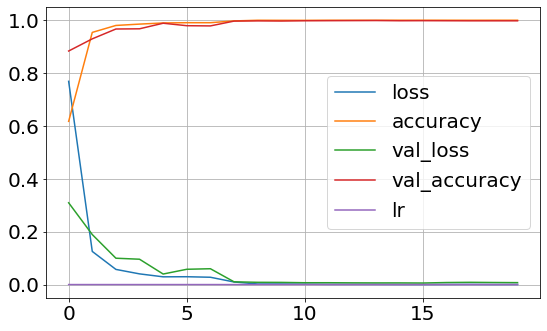

In [ ]:
# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/result/figure/learning_curve_after_unfreezing.pdf')
plt.show()

In [ ]:
# Load the saved model
model.load_weights(filepath=abspath_curr + '/result/Xception_model.h5')

In [ ]:
loss, accuracy = model.evaluate(data_test)

152/152 [==============================] - 535s 3s/step - loss: 4.6971 - accuracy: 0.3900
